This is a derivation of QP production by DM scattering. Following the supplementary material of [this work](https://www.google.com/search?client=safari&rls=en&q=Directional+Detection+of+Light+Dark+Matter+in+Superconductors++Yonit+Hochberg%2C1+Eric+David+Kramer%2C1+Noah+Kurinsky%2C2%2C+3%2C+4+and+Benjamin+V.+Lehmann%2C5%2C&ie=UTF-8&oe=UTF-8).

# DM Interactions

Following [Noah's calculation](https://arxiv.org/pdf/2601.02474), the differential DM scattering rate per unit target mass:

$$
\frac{d \Gamma}{d \omega}=\frac{\pi \bar{\sigma}_e \rho_\chi}{\rho_{\mathrm{T}} m_\chi \mu_{e \chi}^2} \int d^3 \mathbf{v} f_\chi(\mathbf{v}) \int \frac{d^3 \mathbf{q}}{(2 \pi)^3} \mathcal{F}^2(q) \frac{q^2}{2 \pi \alpha} \operatorname{Im}\left(-\frac{1}{\epsilon_L(\omega, \mathbf{q})}\right) \delta\left(\omega-\omega_{\mathbf{q}}\right)
$$

- $\operatorname{Im}\left(-1 / \epsilon_L(\omega, \mathbf{q})\right)$ is the loss function of the material.
    - For bulk limit, it can be calculated by isotropic Lindhard function with a theoretical close form.
    - For thin films ($d^{-1} \ll q$), there is additional momenta-dependent corrections detailed in the QROCODILE paper. 
    - For both cases, there is an additional correction factor near SC gap: $$f_{\mathrm{eff}}(\omega) \approx \begin{cases}1-\frac{\omega-2 \Delta}{4 \Delta} & 2 \Delta<\omega<4 \Delta \\ \frac{1}{2} & 4 \Delta<\omega\end{cases}$$
- $\mu_{e \chi} \equiv m_e m_\chi / (m_e + m_\chi)$ is the reduced mass.
- $\bar{\sigma}_e=\left(\mu_{e \chi}^2 / \pi\right)\left|V\left(q_0\right)\right|^2$ is the fiducial cross section.
    - $q_0=\alpha m_e$ is a reference momentum. 
    - $V(q)=g_{e \chi}^2\left(q^2+m_\phi^2\right)^{-1}$ is a Yukawa potential.
- The ambient DM density is $\rho_\chi\approx 0.4~ \mathrm{GeV/cm^3}$.
- $f_\chi(\mathbf{v})$ is the SHM with $v_0=220 \mathrm{~km} / \mathrm{s}, v_{\oplus}=232 \mathrm{~km} / \mathrm{s}, \text { and } v_{\mathrm{esc}}=540 \mathrm{~km} / \mathrm{s}$. 
    - The integral can be simplified to halo integral by `wimpartes`:$$\int d^3 \mathbf{v} f_\chi(\mathbf{v}) \cdot \rightarrow \int_{0}^{\infin} f_\mathrm{halo}(v) \cdot$$
- $\mathcal{F}^2(q)=|V(q)|^2 /\left|V\left(q_0\right)\right|^2$ is the form factor.
    - For light mediator case, it is $\mathcal{F}^2(q)=\left(q_0 / q\right)^4$.
- The transferred energy in the scattering process by kinematics is $\omega_{\mathbf{q}}=\mathbf{q} \cdot \mathbf{v}-q^2 / 2 m_\chi$

$$
\begin{align}
\frac{d \Gamma}{d \omega} &= \gamma \int_{0}^{\infin} dv f_\mathrm{halo}(v) \int d^3 \mathbf{q} g(\omega, q)\delta\left(\omega- qv \cos \theta + q^2 / 2 m_\chi\right) \\ 
&= \gamma \int_{0}^{\infin} dv f_\mathrm{halo}(v) \int_{0}^{\infin}d q ~(2\pi) q^2 g(\omega, q) \int_{-1}^{1} d \cos \theta~ \delta\left(\omega- qv \cos \theta + q^2 / 2 m_\chi\right) \\
&= \gamma \int_{0}^{\infin} dv f_\mathrm{halo}(v) \int_{0}^{\infin}d q ~(2\pi) q^2 g(\omega, q) \int_{-1}^{1} d \cos \theta~ \frac{1}{qv} \delta\left( \cos \theta-\frac{q}{2 m_\chi v}-\frac{\omega}{qv}  \right) \\
&=2\pi \gamma \int_{v_\mathrm{min}}^{\infin} dv \frac{f_\mathrm{halo}(v)}{v} \int_{q_-}^{q_+}d q g(\omega, q) q
\end{align}
$$
- $\gamma \equiv \frac{\pi \bar{\sigma}_e \rho_\chi}{\rho_{\mathrm{T}} m_\chi \mu_{e \chi}^2}$
- $g(\omega, q) \equiv \frac{1}{(2 \pi)^3} \left(\alpha m_e / q\right)^4\frac{q^2}{2 \pi \alpha}\operatorname{Im}\left(-\frac{1}{\epsilon_L(\omega, \mathbf{q})}\right)$ where I neglected direction dependence of $q$.
- $q_\pm = m_\chi v \pm \sqrt{m_\chi^2 v^2 -2\omega m_\chi}$ are boundaries that satisfy $-1\leq\frac{q}{2 m_\chi v}+\frac{\omega}{q v}\leq1$ so that the integral of $\cos \theta$ over $\delta (\cdot)$ is $1$ rather than $0$.
    - This also requires $v_\mathrm{min}=\sqrt{2\omega/m_\chi}$

In summary, 

$$
\frac{d \Gamma}{d \omega}=\frac{\pi \bar{\sigma}_e \rho_\chi}{\rho_{\mathrm{T}} m_\chi \mu_{e \chi}^2} \int_{\sqrt{2 \omega / m_\chi}}^{\infin} \frac{f_{\text {halo }}(v)}{v} \int_{m_\chi v - \sqrt{m_\chi^2 v^2-2 \omega m_\chi}}^{m_\chi v + \sqrt{m_\chi^2 v^2-2 \omega m_\chi}} dq \frac{q^3}{(2 \pi )^3 \alpha} \mathcal{F}^2(q) \mathrm{Im}\left(-\frac{1}{\epsilon_L (\omega, q)}\right)
$$

We get this for light mediator

$$
\frac{d \Gamma}{d \omega} = \frac{ \bar{\sigma}_e \rho_\chi \alpha^3 m_e^2 (m_e+m_\chi)^2}{8 \pi^2 \rho_{\mathrm{T}} m_\chi^3} \int_{\sqrt{2\omega/m_\chi}}^{\infty} d v \frac{f_{\text {halo }}(v)}{v} \int_{m_\chi v - \sqrt{m_\chi^2 v^2-2 \omega m_\chi}}^{m_\chi v + \sqrt{m_\chi^2 v^2-2 \omega m_\chi}} dq ~\frac{1}{q} \operatorname{Im}\left(-\frac{1}{\epsilon_L(\omega, q)}\right)
$$

It is worth noting that the integrals are dimensionless, and the overall dimension is $E^{-1}$

## Loss Function

Calculating the thin-film function will be difficult, lucikly Noah did this for us. We can interpolate the three curves over energy. Details:
- Assume no response for $q<1~\mathrm{eV}$.
- Assume no response difference above $q>100~\mathrm{eV}$.

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
plt.style.use('../xenonnt.mplstyle')

import wimprates as wr
import numericalunits as nu
#nu.reset_units(42)  # Fix random seed for deterministic unit scaling
from tqdm import tqdm

/Users/lanqingyuan/Documents/GitHub/wimprates/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(


In [2]:
def create_loss_function_interpolator_grid(
    filepath_1eV='1eV.csv',
    filepath_10eV='10eV.csv',
    filepath_100eV='100eV.csv'
):
    """
    Create a 2D interpolator that can evaluate on grids.
    Interpolates in log-log space for q (both log(q) and log(y)).
    
    The data files use eV units for both omega and q.
    Input omega and q should have proper units (via numericalunits).
    Output is dimensionless (loss function).
    """
    data_1 = np.loadtxt(filepath_1eV, delimiter=',')
    data_10 = np.loadtxt(filepath_10eV, delimiter=',')
    data_100 = np.loadtxt(filepath_100eV, delimiter=',')
    
    # Data is in eV, create interpolators with raw numbers
    interp_q1 = interp1d(data_1[:, 0], data_1[:, 1], 
                         kind='linear', bounds_error=False, fill_value=0.0)
    interp_q10 = interp1d(data_10[:, 0], data_10[:, 1], 
                          kind='linear', bounds_error=False, fill_value=0.0)
    interp_q100 = interp1d(data_100[:, 0], data_100[:, 1], 
                           kind='linear', bounds_error=False, fill_value=0.0)
    
    # q nodes in eV (raw numbers matching the file convention)
    q_nodes_eV = np.array([1.0, 10.0, 100.0])
    log_q_nodes = np.log10(q_nodes_eV)
    
    def interpolate(omega, q):
        """
        Interpolate loss function. Supports scalar, 1D arrays, or 2D grids.
        
        Parameters
        ----------
        omega : float or array-like
            Energy values with units (e.g., 0.5 * nu.eV or 100 * nu.meV).
        q : float or array-like
            Momentum values with units (e.g., 5 * nu.eV).
        
        Returns
        -------
        float or ndarray
            Dimensionless interpolated loss function value(s).
        """
        # Convert inputs from numericalunits to eV (raw numbers)
        omega_eV = np.atleast_1d(omega / nu.eV)
        q_eV = np.atleast_1d(q / nu.eV)
        
        # Clamp q to [1, 100] eV for extrapolation
        q_clamped = np.clip(q_eV, 1.0, 100.0)
        log_q = np.log10(q_clamped)
        
        # Get values at the three q nodes for all omega
        y1 = interp_q1(omega_eV)
        y10 = interp_q10(omega_eV)
        y100 = interp_q100(omega_eV)
        
        # Shape: (len(omega), 3)
        y_nodes = np.column_stack([y1, y10, y100])
        
        # Result shape: (len(omega), len(q))
        result = np.zeros((len(omega_eV), len(q_eV)))
        
        for j, lq in enumerate(log_q):
            if lq <= log_q_nodes[0]:
                result[:, j] = y_nodes[:, 0]
            elif lq >= log_q_nodes[2]:
                result[:, j] = y_nodes[:, 2]
            elif lq <= log_q_nodes[1]:
                t = (lq - log_q_nodes[0]) / (log_q_nodes[1] - log_q_nodes[0])
                # Log interpolation: y = y1^(1-t) * y2^t
                y_lo, y_hi = y_nodes[:, 0], y_nodes[:, 1]
                mask = (y_lo > 0) & (y_hi > 0)
                result[mask, j] = np.exp(
                    np.log(y_lo[mask]) * (1 - t) + np.log(y_hi[mask]) * t
                )
                result[~mask, j] = y_lo[~mask] * (1 - t) + y_hi[~mask] * t
            else:
                t = (lq - log_q_nodes[1]) / (log_q_nodes[2] - log_q_nodes[1])
                y_lo, y_hi = y_nodes[:, 1], y_nodes[:, 2]
                mask = (y_lo > 0) & (y_hi > 0)
                result[mask, j] = np.exp(
                    np.log(y_lo[mask]) * (1 - t) + np.log(y_hi[mask]) * t
                )
                result[~mask, j] = y_lo[~mask] * (1 - t) + y_hi[~mask] * t
        
        return np.squeeze(result)
    
    return interpolate

In [3]:
loss_thin_film_interp = create_loss_function_interpolator_grid()

In [4]:
import numpy as np


class LindhardModel:
    """
    Lindhard dielectric function model with configurable material parameters.
    
    Parameters
    ----------
    omegap : float
        Plasma frequency in eV (default: 15.8 eV for Al)
    Efermi : float
        Fermi energy in eV (default: 11.7 eV for Al)
    Gamma_p : float
        Damping rate in eV (default: 1.58 eV for Al)
    """
    
    # Electron mass in eV (constant)
    me = 511e3
    
    def __init__(self, omegap=15.8, Efermi=11.7, Gamma_p=1.58):
        self.omegap = omegap
        self.Efermi = Efermi
        self.Gamma_p = Gamma_p
        # Derived quantities
        self.kfermi = np.sqrt(2 * self.me * self.Efermi)
        self.vfermi = self.kfermi / self.me
    
    def Q_plus(self, omega, q):
        """Q+ function for Lindhard dielectric."""
        return (q / (2 * self.kfermi) 
                + self.me / (q * self.kfermi) * (omega + 1j * self.Gamma_p))
    
    def Q_minus(self, omega, q):
        """Q- function for Lindhard dielectric."""
        return (q / (2 * self.kfermi) 
                - self.me / (q * self.kfermi) * (omega + 1j * self.Gamma_p))
    
    def F_plus(self, omega, q):
        """F+ function for Lindhard dielectric."""
        Q = self.Q_plus(omega, q)
        return self.kfermi / (4 * q) * (1 - Q**2) * np.log((Q + 1) / (Q - 1))
    
    def F_minus(self, omega, q):
        """F- function for Lindhard dielectric."""
        Q = self.Q_minus(omega, q)
        return self.kfermi / (4 * q) * (1 - Q**2) * np.log((Q + 1) / (Q - 1))
    
    def epsilon(self, omega, q):
        """
        Lindhard dielectric function.
        
        Parameters
        ----------
        omega : float or array-like
            Energy transfer in eV
        q : float or array-like
            Momentum transfer in eV
        
        Returns
        -------
        complex
            Lindhard dielectric function value
        """
        return (1 + 3 * self.omegap**2 / (q**2 * self.vfermi**2) 
                * (0.5 + self.F_plus(omega, q) + self.F_minus(omega, q)))
    
    def loss_function(self, omega, q):
        """
        Loss function Im(-1/ε_L) from Lindhard dielectric.
        
        Parameters
        ----------
        omega : float or array-like
            Energy transfer with units (e.g., nu.eV)
        q : float or array-like
            Momentum transfer with units (e.g., nu.eV)
        
        Returns
        -------
        float or ndarray
            Loss function value (dimensionless).
            If both are arrays, returns 2D array with shape (len(omega), len(q)).
        """
        omega_eV = np.atleast_1d(omega / nu.eV)
        q_eV = np.atleast_1d(q / nu.eV)
        
        # Numerical stability: clamp q to minimum 100 eV
        q_clamped = np.clip(q_eV, 100, None)
        
        # Broadcasting: omega[:, None] shape (N, 1), q_clamped shape (M,)
        eps = self.epsilon(omega_eV[:, np.newaxis], q_clamped[np.newaxis, :])
        loss = np.imag(-1 / eps)
        
        return np.squeeze(loss)


# Default model instance for Al (backward compatibility)
_Al_lindhard = LindhardModel()
_WSi_lindhard = LindhardModel(omegap=10.8, Efermi=7.0, Gamma_p=0.7)


def loss_function_lindhard(omega, q, model="Al"):
    """
    Loss function Im(-1/ε_L) from Lindhard dielectric.
    
    Parameters
    ----------
    omega : float or array-like
        Energy transfer with units (e.g., nu.eV)
    q : float or array-like
        Momentum transfer with units (e.g., nu.eV)
    model : LindhardModel, optional
        Lindhard model with custom parameters. If None, uses default Al parameters.
    
    Returns
    -------
    float or ndarray
        Loss function value (dimensionless).
        If both are arrays, returns 2D array with shape (len(omega), len(q)).
    """
    if model == "Al":
        model = _Al_lindhard
    elif model == "WSi":
        model = _WSi_lindhard
    else:
        raise ValueError(f"Invalid model: {model}")

    return model.loss_function(omega, q)


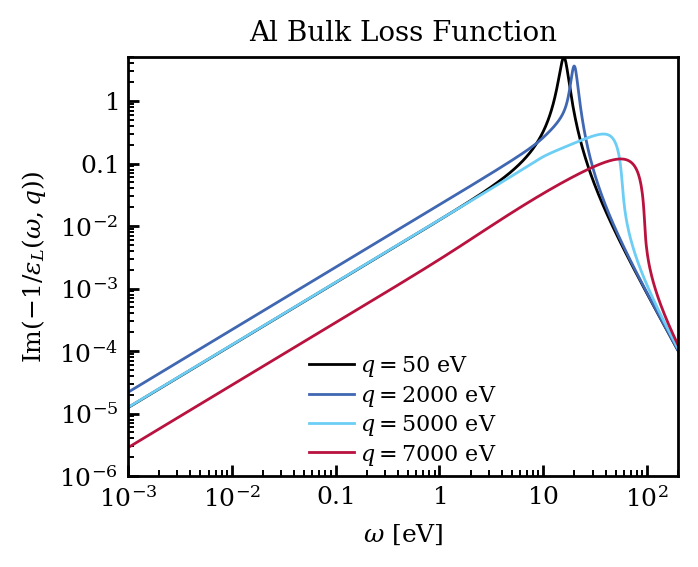

In [5]:
omegas_eV = np.logspace(np.log10(5e-4), np.log10(2e2), 1000) * nu.eV
qs_eV = np.array([50, 2000, 5000, 7000]) * nu.eV
for q in qs_eV:
    loss_q = loss_function_lindhard(omegas_eV, q)
    plt.plot(omegas_eV/nu.eV, loss_q, label=r"$q={}~$eV".format(round(q/nu.eV)))

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-3, 2e2)
plt.ylim(1e-6, 5)
plt.xlabel(r"$\omega$ [eV]")
plt.ylabel(r"$\mathrm{Im}\left(-1/\epsilon_L(\omega, q)\right)$")
plt.title("Al Bulk Loss Function")
plt.show()



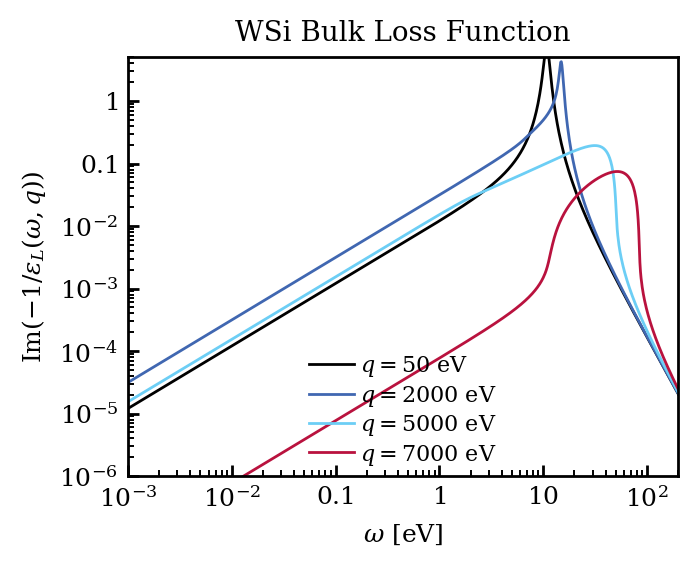

In [6]:
for q in qs_eV:
    loss_q = loss_function_lindhard(omegas_eV, q, model="WSi")
    plt.plot(omegas_eV/nu.eV, loss_q, label=r"$q={}~$eV".format(round(q/nu.eV)))

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-3, 2e2)
plt.ylim(1e-6, 5)
plt.xlabel(r"$\omega$ [eV]")
plt.ylabel(r"$\mathrm{Im}\left(-1/\epsilon_L(\omega, q)\right)$")
plt.title("WSi Bulk Loss Function")
plt.show()

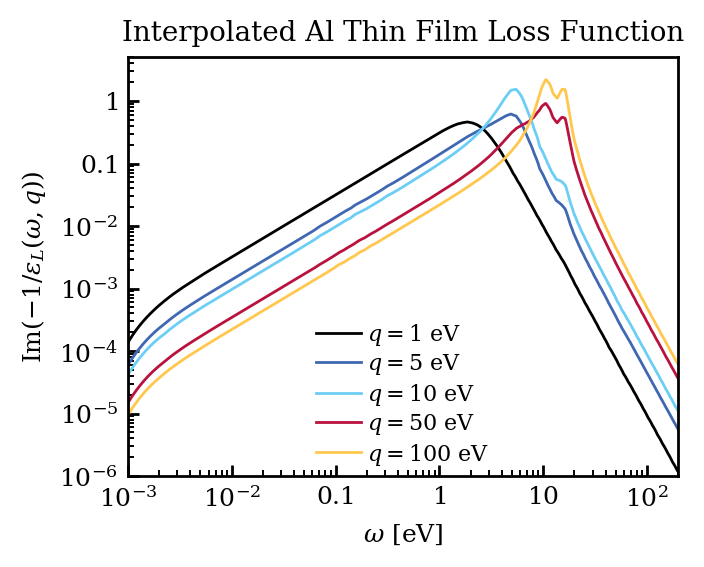

In [7]:
omegas_eV = np.logspace(np.log10(5e-4), np.log10(2e2), 1000) * nu.eV
qs_eV = np.array([1, 5, 10, 50, 100]) * nu.eV
for q in qs_eV:
    loss_q = loss_thin_film_interp(omegas_eV, q)
    plt.plot(omegas_eV/nu.eV, loss_q, label=r"$q={}~$eV".format(int(q/nu.eV)))

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-3, 2e2)
plt.ylim(1e-6, 5)
plt.xlabel(r"$\omega$ [eV]")
plt.ylabel(r"$\mathrm{Im}\left(-1/\epsilon_L(\omega, q)\right)$")
plt.title("Interpolated Al Thin Film Loss Function")
plt.show()



In [8]:
def halo_model_chris(v, v_sun=220 * 1e5 * (nu.cm / nu.s), v_rms=270 * 1e5 * (nu.cm / nu.s), v_esc=600 * 1e5 * (nu.cm / nu.s)):
    """
    Calculates the halo model function with unit support.
    
    Parameters:
    -----------
    v : float (with nu units)
        The input velocity.
    v_sun : float (with nu units)
        The velocity of the Sun.
    v_rms : float (with nu units)
        The RMS velocity.
    v_esc : float (with nu units)
        The escape velocity.
        
    Returns:
    --------
    float (with units of 1/velocity)
        The result of the function f[v].
    """
    
    # Term 1: Sqrt[3 / (2 * Pi)]
    # This prefactor is dimensionless
    prefactor = np.sqrt(3.0 / (2.0 * np.pi))
    
    # Term 2: v / (vsun * vrms)
    # If inputs are velocities, this term has units of [1/Velocity]
    linear_term = v / (v_sun * v_rms)
    
    # Term 3: Difference of exponentials
    # The arguments inside exp() must be dimensionless. 
    # Since we are dividing velocity^2 by velocity^2, units cancel automatically.
    
    # Exp[- (3 (v - vsun)^2) / (2 * vrms^2)]
    arg_1 = -(3.0 * (v - v_sun)**2) / (2.0 * v_rms**2)
    exp_1 = np.exp(arg_1)
    
    # Exp[- (3 (v + vsun)^2) / (2 * vrms^2)]
    arg_2 = -(3.0 * (v + v_sun)**2) / (2.0 * v_rms**2)
    exp_2 = np.exp(arg_2)
    
    # Term 4: HeavisideTheta[vesc + vsun - v]
    # We check if (vesc + vsun - v) is positive.
    # The argument to heaviside must be a float, so the units work fine here 
    # as long as they are consistent (which numericalunits handles).
    cutoff = np.heaviside(v_esc + v_sun - v, 1.0)
    
    # Combine all terms
    result = prefactor * linear_term * (exp_1 - exp_2) * cutoff
    
    return result

/Users/lanqingyuan/Documents/GitHub/wimprates/wimprates/halo.py:161: RuntimeWarning: divide by zero encountered in divide
  (v_esc**2 - v_earth_t**2 - v**2)


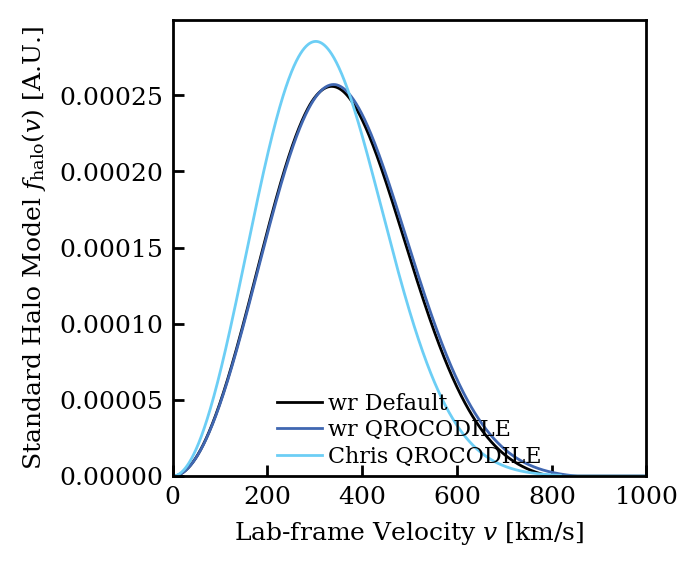

In [9]:
halo_model_default = wr.StandardHaloModel()
halo_model_qrocodile = wr.StandardHaloModel(v_0=240*nu.km/nu.s, v_esc=600*nu.km/nu.s)
v_kms = np.linspace(0, 1000, 1001) *nu.km/nu.s
plt.plot(v_kms/nu.km*nu.s, halo_model_default.velocity_dist(v_kms, t=None), label="wr Default")
plt.plot(v_kms/nu.km*nu.s, halo_model_qrocodile.velocity_dist(v_kms, t=None), label="wr QROCODILE")
plt.plot(v_kms/nu.km*nu.s, halo_model_chris(v_kms), label="Chris QROCODILE")
plt.xlabel(r"Lab-frame Velocity $v$ [km/s]")
plt.ylabel(r"Standard Halo Model $f_\mathrm{halo}(v)$ [A.U.]")
plt.legend()
plt.xlim(0, 1000)
plt.ylim(0,)
plt.show()

In [10]:
np.trapezoid(halo_model_default.velocity_dist(v_kms, t=None), v_kms)

np.float64(0.9700062852054647)

In [11]:
np.trapezoid(halo_model_qrocodile.velocity_dist(v_kms, t=None), v_kms)

np.float64(0.9883289212494977)

In [12]:
np.trapezoid(halo_model_chris(v_kms), v_kms)

np.float64(0.999766282896728)

In [13]:
def get_conversion_factor():
    # 1. Define units explicitly
    # Note: 1 ng = 1e-12 kg (SI prefix for nano is 1e-9, but ng is 1e-12 kg)
    # Wait, strictly speaking:
    # 1 nanogram = 10^-9 grams = 10^-12 kilograms.
    # nu.kg is the base unit for mass.
    ng  = 1e-12 * nu.kg  
    meV = 1e-3  * nu.eV
    s   = nu.s
    eV  = nu.eV
    hbar = nu.hbar
    c    = 299792458 * nu.m/nu.s

    # 2. Calculate the Ratio in SI units
    # X = (ng * meV * s) / eV
    ratio_si = (ng * meV * s) / eV

    # 3. Define the Natural Unit Scaler 
    # Cancels dimensions of [Mass] * [Time]
    natural_unit_scaler = hbar / c**2

    # 4. Compute the dimensionless factor
    return ratio_si / natural_unit_scaler

def calc_rate(
    omegas, m_chi=10*nu.keV, sigma_e=1e-25*nu.cm**2, 
    rho_T=2.7*nu.g/nu.cm**3*(299792458 * nu.m/nu.s)**2, rho_chi=0.4*nu.GeV/nu.cm**3, 
    v_steps=100, q_steps=10, q_min_cutoff=0.1*nu.eV, bulk_limit=True, mediator="light",
    model="Al", halo="wr_default",
    v_0=240*nu.km/nu.s, v_esc=600*nu.km/nu.s,
):
    """
    Get the scattering rate in unit of 1/(meV * s * ng).
    $\frac{d \Gamma}{d \omega}=\frac{\pi \bar{\sigma}_e \rho_\chi}{\rho_{\mathrm{T}} m_\chi \mu_{e \chi}^2} \int_{\sqrt{2 \omega / m_\chi}}^{\infty} \frac{f_{\text {halo }}(v)}{v} \int_{m_\chi v-\sqrt{m_\chi^2 v^2-2 \omega m_\chi}}^{m_\chi v+\sqrt{m_\chi^2 v^2-2 \omega m_\chi}} d q \frac{q^3}{(2 \pi)^3 \alpha} \mathcal{F}^2(q) \operatorname{Im}\left(-\frac{1}{\epsilon_L(\omega, q)}\right)$

    Parameters
    ----------
    omegas : array-like
        Energy transfer values (with units, e.g., nu.eV)
    m_chi : float
        Dark matter mass (with units)
    sigma_e : float
        Fiducial cross section (with units)
    rho_T : float
        Target mass density (with units)
    rho_chi : float
        Local DM density (with units)
    v_steps : int
        Number of velocity integration points
    q_steps : int
        Number of momentum integration points
    q_min_cutoff : float
        Minimum q value to avoid 1/q divergence (default: 0.1 eV, matches loss 
        function data range)
    bulk_limit : bool
        Whether to use the bulk limit of the Lindhard dielectric function
    mediator : str
        Whether the mediator is heavy or light, which affects the form factor
    v_0 : float
        Local halo velocity (with units)
    v_esc : float
        Escape velocity (with units)
    Returns
    -------
    rate : ndarray
        Differential rate dΓ/dω for each omega value. In natural units with dimension [1/energy].
    """
    m_e = 0.511 * nu.MeV
    mu_e_chi = m_chi * m_e / (m_chi + m_e)
    alpha = 1/137
    c = 299792458 * nu.m/nu.s
    hbar = 6.582119569e-16 * nu.eV * nu.s  # ℏ in eV·s
    hbar_c = hbar * c

    pre_factor = np.pi * (sigma_e/hbar_c**2) * rho_chi / (rho_T * m_chi * mu_e_chi**2)
    
    omegas = np.atleast_1d(omegas)
    v_max = 800 * nu.km/nu.s  # Higher than escape velocity cutoff; SI units
    
    rate_eV = np.zeros(len(omegas))

    if halo == "wr_default":
        halo_model = wr.StandardHaloModel().velocity_dist
    elif halo == "wr_qrocodile":
        halo_model = wr.StandardHaloModel(v_0=240*nu.km/nu.s, v_esc=600*nu.km/nu.s).velocity_dist
    elif halo == "chris_qrocodile":
        halo_model = halo_model_chris
    elif halo == "wr_custom":
        halo_model = wr.StandardHaloModel(v_0=v_0, v_esc=v_esc).velocity_dist
    else:
        raise ValueError(f"Invalid halo model: {halo}")

    for j, omega in enumerate(omegas):
        # v_min for this specific omega
        v_min = np.sqrt(2 * omega / m_chi) * c # SI units
        
        # Skip if v_min exceeds v_max (kinematically forbidden)
        if v_min >= v_max:
            continue

        # Velocity grid for this omega
        v_grid = np.linspace(v_min, v_max, v_steps)
        f_halo = halo_model(v_grid)
        
        # Replace NaN/inf in f_halo with 0 (occurs near escape velocity)
        f_halo = np.where(np.isfinite(f_halo), f_halo, 0.0)
        
        # Compute q integral for each velocity point
        q_integrals = np.zeros(v_steps)

        for i, v in enumerate(v_grid):
            # Convert velocity to dimensionless β = v/c (natural units convention)
            # This ensures q comes out in energy units, matching loss_thin_film_interp's expectation
            beta = v / c
            discriminant = m_chi**2 * beta**2 - 2 * omega * m_chi  # energy²
            if discriminant <= 0:
                continue
            sqrt_disc = np.sqrt(discriminant)  # energy
            q_min = m_chi * beta - sqrt_disc   # momentum in energy units (natural units)
            q_max = m_chi * beta + sqrt_disc
            
            # Enforce minimum q to avoid 1/q divergence and match loss data range
            q_min = max(q_min, q_min_cutoff)
            
            if q_max <= q_min:
                continue
            
            q_grid = np.linspace(q_min, q_max, q_steps) # natural units

            if bulk_limit:
                loss_q = loss_function_lindhard(omega, q_grid, model=model)
            else:
                loss_q = loss_thin_film_interp(omega, q_grid)  # scalar omega, array q

            if mediator == "heavy":
                form_factor = 1
            elif mediator == "light":
                form_factor = (alpha * m_e)**4 / q_grid ** 4
            q_integrand = q_grid**3 / (2*np.pi)**3 / alpha * form_factor * loss_q
            q_integrals[i] = np.trapezoid(q_integrand, q_grid)

        # v integral: ∫ dv (f_halo/v) × [q_integral]
        v_integrand = f_halo / (v_grid/c)* q_integrals # Make v dimensionless
        rate_eV[j] = pre_factor * np.trapezoid(v_integrand, v_grid)

    return rate_eV * nu.eV * get_conversion_factor()
    

In [14]:
# Unit [1/eV], dimension: [1/energy]
rates_1keV = calc_rate(omegas_eV, m_chi=1*nu.keV, sigma_e=1e-25*nu.cm**2, v_steps=500, q_steps=200, halo="chris_qrocodile")
rates_10keV = calc_rate(omegas_eV, m_chi=10*nu.keV, sigma_e=1e-25*nu.cm**2, v_steps=500, q_steps=200, halo="chris_qrocodile")
rates_100keV = calc_rate(omegas_eV, m_chi=100*nu.keV, sigma_e=1e-25*nu.cm**2, v_steps=500, q_steps=200, halo="chris_qrocodile")

In [15]:
# QROCODILE limit corresponding to 15 events/415 hours with 1.64 ng target
rates_100keV_qrocodile = calc_rate(
    omegas_eV, m_chi=100*nu.keV, sigma_e=2.7e-27*nu.cm**2, 
    rho_T=9.3*nu.g/nu.cm**3*(299792458 * nu.m/nu.s)**2, # WSi
    model="WSi", halo="chris_qrocodile"
)

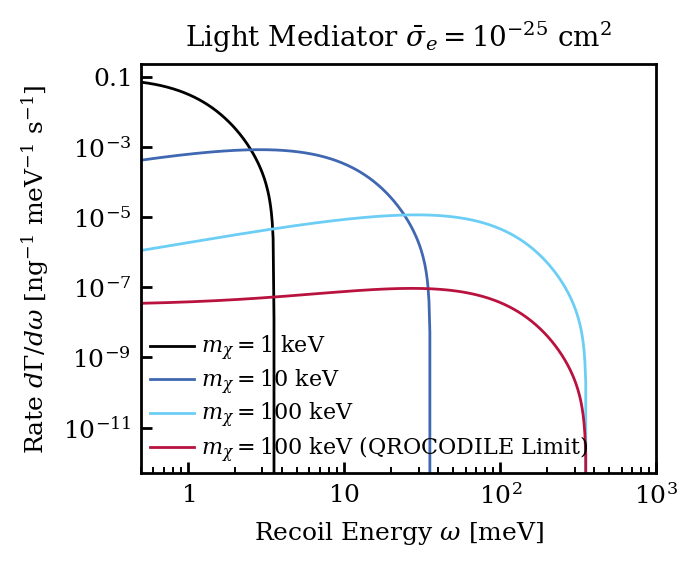

In [16]:
# Convert rate to [events / (nanogram * meV * s)]
plt.plot(omegas_eV/nu.meV, rates_1keV , label=r"$m_\chi=1~\mathrm{keV}$")
plt.plot(omegas_eV/nu.meV, rates_10keV , label=r"$m_\chi=10~\mathrm{keV}$")
plt.plot(omegas_eV/nu.meV, rates_100keV, label=r"$m_\chi=100~\mathrm{keV}$")
plt.plot(omegas_eV/nu.meV, rates_100keV_qrocodile, label=r"$m_\chi=100~\mathrm{keV}$ (QROCODILE Limit)")

plt.yscale("log")
plt.xlabel(r"Recoil Energy $\omega$ [meV]")
plt.ylabel(r"Rate $d\Gamma/d\omega$ [ng$^{-1}$ meV$^{-1}$ s$^{-1}$]")
plt.xlim(0)
plt.legend(loc="best")
plt.title(r"Light Mediator $\bar{\sigma}_e=10^{-25}~\mathrm{cm}^2$")
plt.xlim(0.5, 1000)
plt.xscale("log")
plt.show()


This looks really too high! Let's use the machine we made to predict QROCODILE at the limit, then scale back. This is correct-ish when our computation is right in the shape.

QROCODILE used WSi, which has mass density $\rho_T=9.1~\mathrm{g/cm^3}$. If you believe my calculation above, we can calculate the predicted dark count rate at the corresponding rate by limit (95% CL). The QROCODILE fiducial mass is 1.64 ng. For the main analysis, they have a threshold of 110 meV so $E_\mathrm{thr}=110~\mathrm{meV}$.

$$
\mathrm{DCR}_\mathrm{QROCODILE} = M_\mathrm{QROCODILE} \int_{E_\mathrm{thr}}^{\infin} \frac{d \Gamma}{d \omega} d \omega
$$

We need to get the UL corresponding rate. With 15 observed events, the 95% CL is set by:
$\begin{gathered}\mu_{\text {upper }}=0.5 \times \chi_{0.975}^2\left(2\left(N_{\text {obs }}+1\right)\right) \\ \mu_{\text {upper }}=0.5 \times \chi_{0.975}^2(32) \approx \mathbf{2 4 . 7 4} \text { events }\end{gathered}$

With the assumption that the shape of our calculation is right, but we are missing some scaling, we can just use the raio between the predicted and the observed (95% CL) rate as a correction scalar to our rate calculation. 

In [17]:
dcr_qrocodile_observed = 24.74/415/3600 # Hz. 15 events in 415 hours. 24.74 is the 95% CL UL.

In [18]:
def count_dcr(omegas_meV, rates_ngmevs, sigma_e=1e-25*nu.cm**2, threshold_meV=20, target_mass_ng=1.18, reference_sigma_e=1e-25*nu.cm**2):
    """Count the number of DCR events in a given rate spectrum.
    """
    rates_ngmevs = np.array(rates_ngmevs)
    integrated_rate = np.trapz(rates_ngmevs[omegas_meV>threshold_meV], omegas_meV[omegas_meV>threshold_meV])
    return integrated_rate * target_mass_ng * (sigma_e / reference_sigma_e)


In [19]:
dcr_1keV = count_dcr(omegas_eV/nu.meV, rates_1keV, threshold_meV=20, target_mass_ng=1.18)
dcr_10keV = count_dcr(omegas_eV/nu.meV, rates_10keV, threshold_meV=20, target_mass_ng=1.18)
dcr_100keV = count_dcr(omegas_eV/nu.meV, rates_100keV, threshold_meV=20, target_mass_ng=1.18)

/var/folders/b4/tkxxqysd1pd6vc7155459qcm0000gn/T/ipykernel_70823/3812413383.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integrated_rate = np.trapz(rates_ngmevs[omegas_meV>threshold_meV], omegas_meV[omegas_meV>threshold_meV])


In [20]:
dcr_100keV_qrocodile = count_dcr(
    omegas_eV/nu.meV, rates_100keV_qrocodile, 
    threshold_meV=110, target_mass_ng=1.64, 
    sigma_e=2.7e-27*nu.cm**2, reference_sigma_e=2.7e-25*nu.cm**2 # From QROCODILE limit
)

/var/folders/b4/tkxxqysd1pd6vc7155459qcm0000gn/T/ipykernel_70823/3812413383.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integrated_rate = np.trapz(rates_ngmevs[omegas_meV>threshold_meV], omegas_meV[omegas_meV>threshold_meV])


The scaling I need to multiply with my rate calculation is:

In [21]:
boosted_factor = dcr_qrocodile_observed / dcr_100keV_qrocodile # Ratio of the observed and predicted rate.
boosted_factor

np.float64(741.6676205017231)

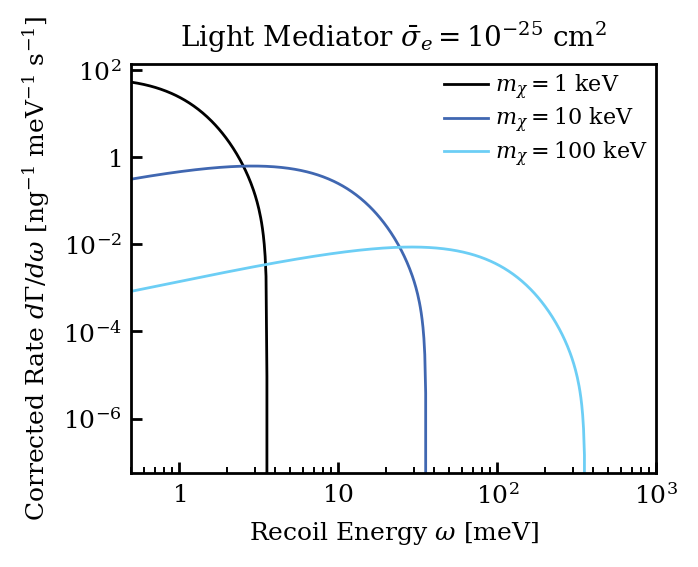

In [22]:
plt.plot(omegas_eV/nu.meV, rates_1keV * boosted_factor, label=r"$m_\chi=1~\mathrm{keV}$")
plt.plot(omegas_eV/nu.meV, rates_10keV * boosted_factor, label=r"$m_\chi=10~\mathrm{keV}$")
plt.plot(omegas_eV/nu.meV, rates_100keV * boosted_factor, label=r"$m_\chi=100~\mathrm{keV}$")
plt.yscale("log")
plt.xlabel(r"Recoil Energy $\omega$ [meV]")
plt.ylabel(r"Corrected Rate $d\Gamma/d\omega$ [ng$^{-1}$ meV$^{-1}$ s$^{-1}$]")
plt.xlim(0)
plt.legend(loc="best")
plt.title(r"Light Mediator $\bar{\sigma}_e=10^{-25}~\mathrm{cm}^2$")
plt.xlim(0.5, 1000)
plt.xscale("log")
plt.show()


# Limit 

## Pure Counting Experiment

Get a first order correct bkg model

In [23]:
def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )

energies_meV = np.linspace(0, 1000, 10001) / 2
bkg_model = 3e-1 * gaussian(energies_meV, 15, 3) + 1e-5
bkg_model[energies_meV<10] = 0

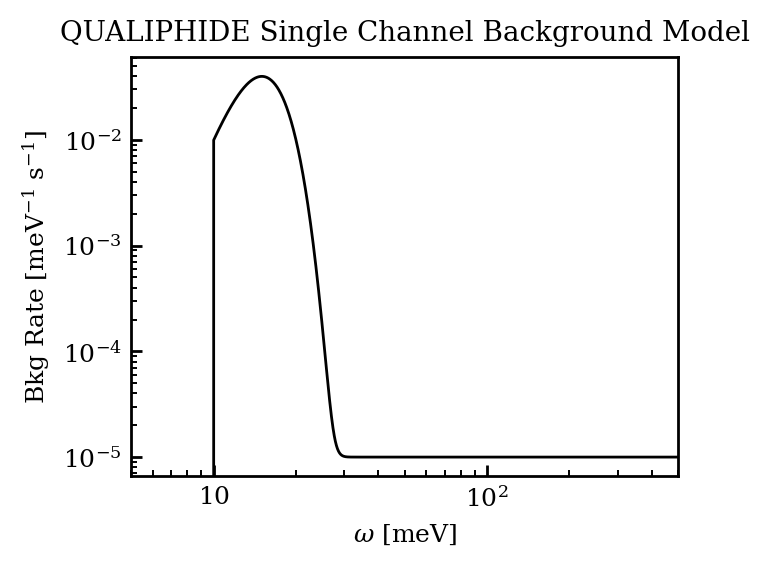

In [24]:
plt.plot(energies_meV, bkg_model)
plt.xlabel(r"$\omega$ [meV]")
plt.ylabel(r"Bkg Rate [meV$^{-1}$ s$^{-1}$]")
plt.xlim(5, 500)
plt.xscale("log")
plt.yscale("log")
plt.title("QUALIPHIDE Single Channel Background Model")
plt.show()


Compute expected DCR at 1e-25 cm2.

In [25]:
from tqdm import tqdm
dcr_hz_dict = {}
masses = np.logspace(np.log10(1), np.log10(1000), 50)*nu.keV
for thr_meV in [5, 10, 20]:
    dcr_hz_array = np.zeros(len(masses))
    dcr_hz_dict[thr_meV] = dcr_hz_array
    for i, m_chi in tqdm(enumerate(masses)):
        rates = calc_rate(omegas_eV, m_chi=m_chi, sigma_e=1e-25*nu.cm**2, v_steps=20, q_steps=10)
        dcr_hz = count_dcr(omegas_eV/nu.meV, rates * boosted_factor, threshold_meV=thr_meV, target_mass_ng=1.18)
        dcr_hz_array[i] = dcr_hz

0it [00:00, ?it/s]


TypeError: StandardHaloModel.velocity_dist() missing 1 required positional argument: 't'

In [ ]:
assumed_qualphide_dcr_Hz = 2e-3 # 2 mHz; idealistic
reference_sigma_e = 1e-25
sensi_dict = {}
for thr_meV in [5, 10]:
    #observed_dcr_hz = np.trapz(bkg_model[energies_meV>thr_meV], energies_meV[energies_meV>thr_meV])
    sensi_dict[thr_meV] = assumed_qualphide_dcr_Hz/ dcr_hz_dict[thr_meV] * reference_sigma_e

In [ ]:
import pandas as pd
import straxion
straxion.register_xenon_colors()

# Existing limits
qrocodile = pd.read_csv('qrocodile_limit.csv', header=None, names=['mass_MeV', 'limit_cm2'])
dd = pd.read_csv("dd_limit.csv", header=None, names=['mass_MeV', 'limit_cm2'])
qrocodile_adv_mass_MeV = 4.4e2/1e3
existing_energy = np.concatenate((
    qrocodile['mass_MeV'][qrocodile['mass_MeV']<qrocodile_adv_mass_MeV]*1e3, 
    dd['mass_MeV'][dd['mass_MeV']>qrocodile_adv_mass_MeV]*1e3
))
existing_limit = np.concatenate((
    qrocodile['limit_cm2'][qrocodile['mass_MeV']<qrocodile_adv_mass_MeV], 
    dd['limit_cm2'][dd['mass_MeV']>qrocodile_adv_mass_MeV]
))


plt.plot(existing_energy, existing_limit, color='xenon_green')
plt.fill_between(existing_energy, existing_limit, 1e-23, color='xenon_green', alpha=0.2)

# QUALIPHIDE-FIR result
thr_meV = 20
observed_dcr_hz = np.trapz(bkg_model[energies_meV>thr_meV], energies_meV[energies_meV>thr_meV])
plt.plot(masses/nu.keV, observed_dcr_hz/dcr_hz_dict[thr_meV]*reference_sigma_e, color='xenon_black', lw=1.5)
plt.fill_between(masses/nu.keV, observed_dcr_hz/dcr_hz_dict[thr_meV]*reference_sigma_e, 1e-23, color='xenon_black', alpha=0.2)

colors = ["xenon_blue", "xenon_light_blue"]
# Put a infinite line at 1e-15 cm2
for i, thr_meV in enumerate([5, 10][::-1]):
    first_non_inf = np.where(sensi_dict[thr_meV]!=np.inf)[0][0]
    plt.plot(
        np.concatenate(([masses[first_non_inf]/nu.keV], masses[first_non_inf:]/nu.keV)), 
        np.concatenate(([1e-15], sensi_dict[thr_meV][first_non_inf:])), 
    label=fr"$E_\mathrm{{thr}}={thr_meV}~\mathrm{{meV}}$", color=colors[i])

# Modulation: effectively gives background model
for i, thr_meV in enumerate([5, 10][::-1]):
    first_non_inf = np.where(sensi_dict[thr_meV]!=np.inf)[0][0]
    plt.plot(
        np.concatenate(([masses[first_non_inf]/nu.keV], masses[first_non_inf:]/nu.keV)), 
        np.concatenate(([1e-15], sensi_dict[thr_meV][first_non_inf:]))/487, 
    color=colors[i], ls="--")

# Resolution: further background suppression
for i, thr_meV in enumerate([5, 10][::-1]):
    first_non_inf = np.where(sensi_dict[thr_meV]!=np.inf)[0][0]
    plt.plot(
        np.concatenate(([masses[first_non_inf]/nu.keV], masses[first_non_inf:]/nu.keV)), 
        np.concatenate(([1e-15], sensi_dict[thr_meV][first_non_inf:]))/487/100, 
    color=colors[i], ls="-.")

# Directionality: additional background suppression
for i, thr_meV in enumerate([5, 10][::-1]):
    first_non_inf = np.where(sensi_dict[thr_meV]!=np.inf)[0][0]
    plt.plot(
        np.concatenate(([masses[first_non_inf]/nu.keV], masses[first_non_inf:]/nu.keV)), 
        np.concatenate(([1e-15], sensi_dict[thr_meV][first_non_inf:]))/487/100/50, 
    color=colors[i], ls=":")

plt.text(1.4e2, 5e-27, "Existing Limits", color='xenon_green', rotation=0, fontsize=7)

#plt.text(20, 3e-27, r"Low-$E$ Background-free", color='xenon_black', rotation=0, fontsize=7)
plt.text(9, 1e-24, "QUALIPHIDE-FIR", color='xenon_black', rotation=0, fontsize=7)
plt.text(12, 0.2e-24, "(Preliminary)", color='xenon_black', rotation=0, fontsize=7)

plt.text(25, 1e-27, "Counting", rotation=10, fontsize=7)
plt.text(25, 2e-30, "&Modulation", rotation=10, fontsize=7)
plt.text(25, 2e-32, "&Resolution", rotation=10, fontsize=7)
plt.text(25, 3e-34, "&Directionality", rotation=10, fontsize=7)


plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$m_\chi$ [keV]")
plt.ylabel(r"Light Mediator $\bar{\sigma}_e$ [cm$^{{2}}$]")
plt.xlim(1.3, 1e3)
#plt.title("Counting Experiment with QUALIPHIDE-FIR")
plt.ylim(1e-34, 1e-23)
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=7)
#plt.tight_layout()
#plt.legend(loc="best")
#plt.savefig("qualiphide_er_sensi.pdf", bbox_inches="tight")
plt.show()

In [ ]:
import pandas as pd
import straxion
straxion.register_xenon_colors()

# Existing limits
qrocodile = pd.read_csv('qrocodile_limit.csv', header=None, names=['mass_MeV', 'limit_cm2'])
dd = pd.read_csv("dd_limit.csv", header=None, names=['mass_MeV', 'limit_cm2'])
qrocodile_adv_mass_MeV = 4.4e2/1e3
existing_energy = np.concatenate((
    qrocodile['mass_MeV'][qrocodile['mass_MeV']<qrocodile_adv_mass_MeV]*1e3, 
    dd['mass_MeV'][dd['mass_MeV']>qrocodile_adv_mass_MeV]*1e3
))
existing_limit = np.concatenate((
    qrocodile['limit_cm2'][qrocodile['mass_MeV']<qrocodile_adv_mass_MeV], 
    dd['limit_cm2'][dd['mass_MeV']>qrocodile_adv_mass_MeV]
))


plt.plot(existing_energy, existing_limit, color='xenon_green')
plt.fill_between(existing_energy, existing_limit, 1e-23, color='xenon_green', alpha=0.2)

# QUALIPHIDE-FIR result
thr_meV = 20
observed_dcr_hz = np.trapz(bkg_model[energies_meV>thr_meV], energies_meV[energies_meV>thr_meV])
plt.plot(masses/nu.keV, observed_dcr_hz/dcr_hz_dict[thr_meV]*reference_sigma_e, color='xenon_black', lw=1.5)
plt.fill_between(masses/nu.keV, observed_dcr_hz/dcr_hz_dict[thr_meV]*reference_sigma_e, 1e-23, color='xenon_black', alpha=0.2)

colors = ["xenon_blue", "xenon_light_blue"]
# Put a infinite line at 1e-15 cm2
for i, thr_meV in enumerate([5, 10][::-1]):
    first_non_inf = np.where(sensi_dict[thr_meV]!=np.inf)[0][0]
    plt.plot(
        np.concatenate(([masses[first_non_inf]/nu.keV], masses[first_non_inf:]/nu.keV)), 
        np.concatenate(([1e-15], sensi_dict[thr_meV][first_non_inf:])), 
    label=fr"$E_\mathrm{{thr}}={thr_meV}~\mathrm{{meV}}$", color=colors[i])

plt.text(1.4e2, 5e-27, "Existing Limits", color='xenon_green', rotation=0, fontsize=7)

#plt.text(20, 3e-27, r"Low-$E$ Background-free", color='xenon_black', rotation=0, fontsize=7)
plt.text(9, 1e-24, "QUALIPHIDE-FIR", color='xenon_black', rotation=0, fontsize=7)
plt.text(12, 0.2e-24, "(Preliminary)", color='xenon_black', rotation=0, fontsize=7)

#plt.text(25, 1e-27, "Counting", rotation=10, fontsize=7)
#plt.text(25, 2e-30, "&Modulation", rotation=10, fontsize=7)
#plt.text(25, 2e-32, "&Resolution", rotation=10, fontsize=7)
#plt.text(25, 3e-34, "&Directionality", rotation=10, fontsize=7)


plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$m_\chi$ [keV]")
plt.ylabel(r"Light Mediator $\bar{\sigma}_e$ [cm$^{{2}}$]")
plt.xlim(1.3, 1e3)
#plt.title("Counting Experiment with QUALIPHIDE-FIR")
plt.ylim(1e-27, 1e-23)
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=7)
#plt.tight_layout()
#plt.legend(loc="best")
#plt.savefig("qualiphide_er_sensi.pdf", bbox_inches="tight")
plt.show()

In [ ]:
print("QROCODILE improvement due to background characterization", np.sqrt(10**7*165*24/415))

Assume we also run 1 year and have 2400 pixels

In [ ]:
print("QUALIPHIDE improvement due to background characterization", np.sqrt(2400 * 165*24/40))